In [1]:
# importing important libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import yfinance as yf

In [2]:
# loading csv file into dataframe
df = pd.read_csv('NFLX.csv')

In [3]:
# checking dataframes first 5 entries
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-02-05,262.000000,267.899994,250.029999,254.259995,254.259995,11896100
1,2018-02-06,247.699997,266.700012,245.000000,265.720001,265.720001,12595800
2,2018-02-07,266.579987,272.450012,264.329987,264.559998,264.559998,8981500
3,2018-02-08,267.079987,267.619995,250.000000,250.100006,250.100006,9306700
4,2018-02-09,253.850006,255.800003,236.110001,249.470001,249.470001,16906900


In [4]:
# Checking the shape of the dataset
df.shape

(1009, 7)

In [5]:
# Checking all the information about the categorical and numerical columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1009 entries, 0 to 1008
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1009 non-null   object 
 1   Open       1009 non-null   float64
 2   High       1009 non-null   float64
 3   Low        1009 non-null   float64
 4   Close      1009 non-null   float64
 5   Adj Close  1009 non-null   float64
 6   Volume     1009 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 55.3+ KB


In [6]:
# Descriptive Statistics - Numerical columns
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1009.000000,1009.000000,1009.000000,1009.000000,1009.000000,1.009000e+03
mean,419.059673,425.320703,412.374044,419.000733,419.000733,7.570685e+06
std,108.537532,109.262960,107.555867,108.289999,108.289999,5.465535e+06
min,233.919998,250.649994,231.229996,233.880005,233.880005,1.144000e+06
25%,331.489990,336.299988,326.000000,331.619995,331.619995,4.091900e+06
50%,377.769989,383.010010,370.880005,378.670013,378.670013,5.934500e+06
75%,509.130005,515.630005,502.529999,509.079987,509.079987,9.322400e+06
max,692.349976,700.989990,686.090027,691.690002,691.690002,5.890430e+07


In [7]:
# Checking the null values
df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

There are no null values.



In [8]:
# reseting the date as index
df.set_index('Date',drop=True,inplace=True) 
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-02-05,262.000000,267.899994,250.029999,254.259995,254.259995,11896100
2018-02-06,247.699997,266.700012,245.000000,265.720001,265.720001,12595800
2018-02-07,266.579987,272.450012,264.329987,264.559998,264.559998,8981500
2018-02-08,267.079987,267.619995,250.000000,250.100006,250.100006,9306700
2018-02-09,253.850006,255.800003,236.110001,249.470001,249.470001,16906900


array([[<Axes: title={'center': 'Open'}>,
        <Axes: title={'center': 'High'}>],
       [<Axes: title={'center': 'Low'}>,
        <Axes: title={'center': 'Close'}>],
       [<Axes: title={'center': 'Adj Close'}>,
        <Axes: title={'center': 'Volume'}>]], dtype=object)

<Figure size 1500x3000 with 0 Axes>

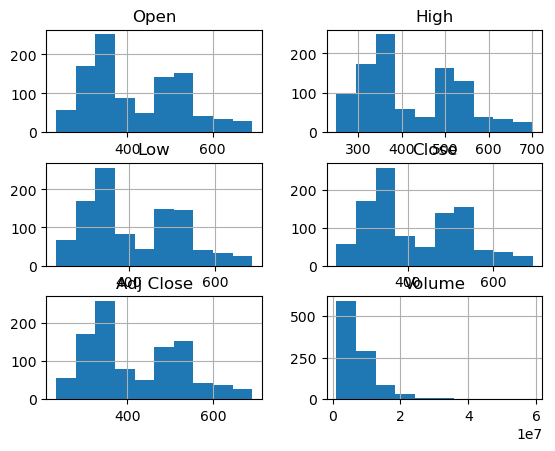

In [9]:
# ploting histogram
plt.figure(figsize = (15,30))
df.hist()

# EDA analysis

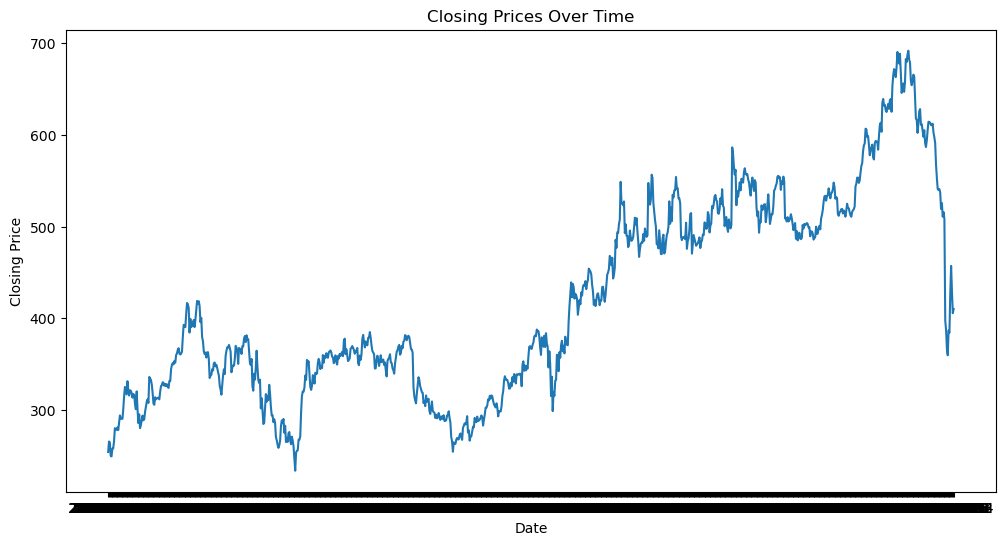

In [10]:
# Plot closing prices over time
plt.figure(figsize=(12, 6))
sns.lineplot(x=df.index, y=df['Close'])
plt.title('Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.show()

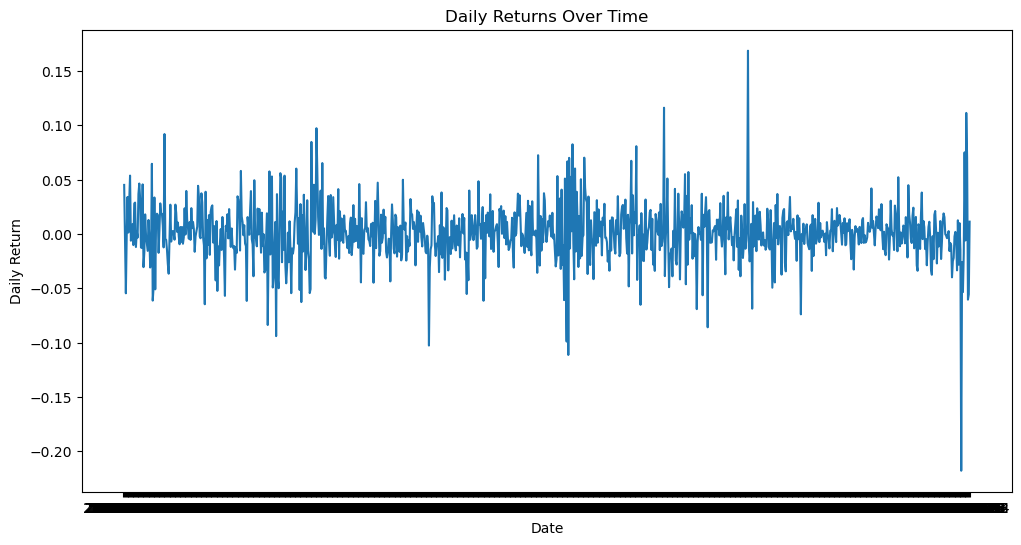

In [11]:
# Plot daily returns
df['Daily_Return'] = df['Close'].pct_change()
plt.figure(figsize=(12, 6))
sns.lineplot(x=df.index, y=df['Daily_Return'])
plt.title('Daily Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.show()

In [12]:
# Create a column for the target variable (next day's closing price)
df['Next_Close'] = df['Close'].shift(-1)

In [13]:
# Scaling the data
scaler = MinMaxScaler(feature_range=(0, 1))
df[['Close', 'Next_Close']] = scaler.fit_transform(df[['Close', 'Next_Close']])

In [14]:
# Create sequences for LSTM
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        target = data[i+seq_length]
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)

In [15]:
# Set sequence length and split the data
sequence_length = 3
X, y = create_sequences(df[['Close', 'Next_Close']].values, sequence_length)

In [16]:
# Splitting the data
train_size = int(len(X) * 0.80)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [17]:
# Define the LSTM model
model = Sequential()
model.add(LSTM(units=50, activation='relu', input_shape=(sequence_length, 2)))
model.add(Dense(units=2))
model.compile(optimizer='adam', loss='mean_squared_error')

C:\Users\palla\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [18]:
# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, callbacks=[early_stopping])

Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.1003 - val_loss: 0.2372
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0445 - val_loss: 0.0674
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0102 - val_loss: 0.0089
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0044 - val_loss: 0.0067
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0024 - val_loss: 0.0018
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0010 - val_loss: 0.0015
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.5360e-04 - val_loss: 0.0014
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.4656e-04 - val_loss: 0.0014
Epoch 9/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.6116e-04 - val_loss: 0.0013
Epoch 10/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.8366e-04 - val_loss: 0.0013
Epoch 11/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.9742e-04 - val_loss: 0.0013
Epoch 12/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - 

In [19]:
# Predictions of the model
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [20]:
# Inverse transform the predictions to original state
train_predictions_inv = scaler.inverse_transform(train_predictions)
test_predictions_inv = scaler.inverse_transform(test_predictions)
y_train_inv = scaler.inverse_transform(y_train)
y_test_inv = scaler.inverse_transform(y_test)

In [21]:
df.isnull().sum()

Open            0
High            0
Low             0
Close           0
Adj Close       0
Volume          0
Daily_Return    1
Next_Close      1
dtype: int64

In [22]:
df['Next_Close'].dtype

dtype('float64')

In [23]:
# Treating the null values
df['Next_Close'].fillna(df['Next_Close'].mean(), inplace=True)
df['Daily_Return'].fillna(df['Daily_Return'].mean(), inplace=True)

C:\Users\palla\AppData\Local\Temp\ipykernel_23408\1316444527.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Next_Close'].fillna(df['Next_Close'].mean(), inplace=True)
C:\Users\palla\AppData\Local\Temp\ipykernel_23408\1316444527.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a 

In [24]:
df.isnull().sum()

Open            0
High            0
Low             0
Close           0
Adj Close       0
Volume          0
Daily_Return    0
Next_Close      0
dtype: int64

In [25]:
# Calculate RMSE

print("NaN values in y_train_inv:", np.isnan(y_train_inv).any())
print("NaN values in y_test_inv:", np.isnan(y_test_inv).any())

NaN values in y_train_inv: False
NaN values in y_test_inv: True


In [26]:
from numpy import nan_to_num

# Replace NaN values with a specific number, for example, 0
y_test_inv = nan_to_num(y_test_inv, nan=0)
test_predictions_inv = nan_to_num(test_predictions_inv, nan=0)

# Now compute the RMSE
test_rmse = np.sqrt(mean_squared_error(y_test_inv, test_predictions_inv))

In [27]:
train_rmse = np.sqrt(mean_squared_error(y_train_inv, train_predictions_inv))


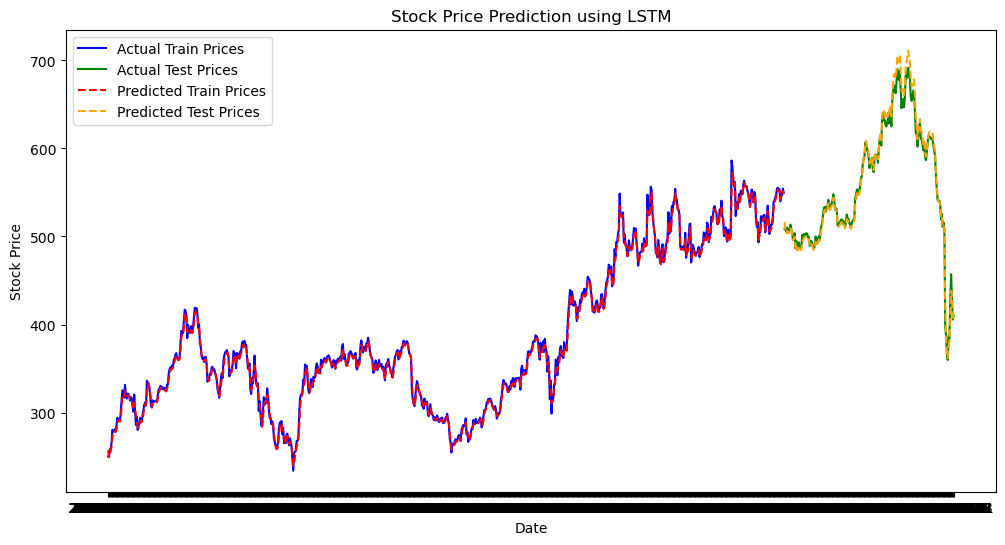

In [28]:
# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(df.index[:len(y_train_inv)], y_train_inv[:, 0], label='Actual Train Prices', color='blue')
plt.plot(df.index[len(y_train_inv):len(y_train_inv)+len(y_test_inv)], y_test_inv[:, 0], label='Actual Test Prices', color='green')
plt.plot(df.index[:len(train_predictions_inv)], train_predictions_inv[:, 0], label='Predicted Train Prices', linestyle='--', color='red')
plt.plot(df.index[len(y_train_inv):len(y_train_inv)+len(test_predictions_inv)], test_predictions_inv[:, 0], label='Predicted Test Prices', linestyle='--', color='orange')
plt.title('Stock Price Prediction using LSTM')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [29]:
# Print the evaluation results
print(f'Train RMSE: {train_rmse:.2f}')
print(f'Test RMSE: {test_rmse:.2f}')

Train RMSE: 8.40
Test RMSE: 23.90


## This indicates that a lower RMSE represents better model performance.